问题描述：
在给定区间内，求函数 f(x) = x * sin(10 * π * x) + 2.0 的最大值。

我们选择这个函数是因为：
它不是一个简单的单调函数，用传统方法求解不方便。
它有多个局部最大值，容易让其他优化算法陷入“局部最优解”。
它的图形很直观，便于我们可视化遗传算法的搜索过程。
我们将在这个函数的定义域 x ∈ [-1, 2] 内寻找最大值。

遗传算法如何解决这个问题？

个体/染色体 (Chromosome)：一个潜在的解，也就是一个 x 值。但我们不能直接用 x，而是用二进制串来编码它。比如，用一个10位的二进制数来表示 x 的值。
基因 (Gene)：二进制串中的每一位（0或1）。
种群 (Population)：一组随机生成的二进制串，代表了在 [-1, 2] 区间内的一堆随机 x 点。
适应度函数 (Fitness Function)：就是我们要求解的函数 f(x) 本身。f(x) 的值越大，代表这个个体（解）越好，适应度越高。
选择 (Selection)：f(x) 值大的个体（点）更有可能被选中，进入下一代。
交叉 (Crossover)：两个被选中的父代二进制串交换部分片段，生成新的子代二进制串。这相当于在解空间中进行探索。
变异 (Mutation)：以很小的概率随机翻转子代二进制串中的某一位（0变1，1变0）。这能防止算法过早收敛，增加跳出局部最优解的可能性。

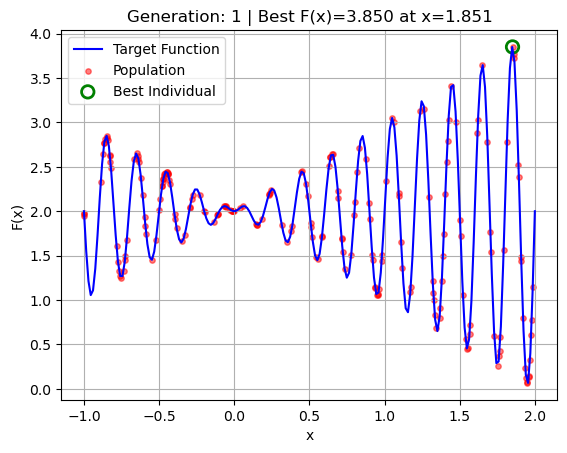


进化完成!
找到的最优解 x = 1.2499885557335775
对应的函数最大值 F(x) = 3.2499884749446766


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 定义问题和遗传算法的超参数 ---
DNA_SIZE = 16          # DNA的长度（二进制位数），位数越多，x的精度越高
POP_SIZE = 200         # 种群大小
CROSSOVER_RATE = 0.8   # 交叉概率
MUTATION_RATE = 0.005  # 变异概率
N_GENERATIONS = 100    # 迭代的代数
X_BOUND = [-1, 2]      # x的取值范围

# --- 2. 目标函数与适应度函数 ---
def F(x):
    # 我们要找最大值的函数
    return x * np.sin(10 * np.pi * x) + 2.0

def get_fitness(pred):
    # 适应度函数，这里直接用函数值
    # 因为函数值可能为负，而适应度通常为正，我们加上一个偏移量或取max(0, F(x))
    return pred + 1e-3 - np.min(pred) # 加上一个极小值防止适应度为0

# --- 3. 编码与解码 ---
def translateDNA(pop):
    # 将二进制的DNA解码为定义域内的十进制数
    # pop shape: (POP_SIZE, DNA_SIZE)
    # .dot(2**np.arange(DNA_SIZE)[::-1]) -> 二进制转十进制
    x_decimal = pop.dot(2 ** np.arange(DNA_SIZE)[::-1]) / float(2**DNA_SIZE - 1)
    x_real = x_decimal * (X_BOUND[1] - X_BOUND[0]) + X_BOUND[0]
    return x_real

# --- 4. 核心操作：选择、交叉、变异 ---
def select(pop, fitness):
    # 轮盘赌选择法
    # 适应度越高的个体，被选中的概率越大
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,
                           p=fitness/fitness.sum())
    return pop[idx]

def crossover(parent, pop):
    # 交叉操作
    if np.random.rand() < CROSSOVER_RATE:
        i_ = np.random.randint(0, POP_SIZE, size=1) # 随机选择另一个个体
        cross_points = np.random.randint(0, 2, size=DNA_SIZE).astype(np.bool_)
        parent[cross_points] = pop[i_, cross_points] # 将选择的基因片段进行交换
    return parent

def mutate(child):
    # 变异操作
    for point in range(DNA_SIZE):
        if np.random.rand() < MUTATION_RATE:
            child[point] = 1 if child[point] == 0 else 0 # 翻转基因位
    return child

# --- 5. 主程序 ---
# 初始化种群
pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE))

# 开启matplotlib的交互模式用于动画
plt.ion()
fig, ax = plt.subplots()

for generation in range(N_GENERATIONS):
    # 解码得到x的值
    x = translateDNA(pop)
    # 计算函数值
    pred = F(x)
    # 计算适应度
    fitness = get_fitness(pred)

    # 找到当前代最好的个体
    best_idx = np.argmax(fitness)
    best_x = x[best_idx]
    best_y = pred[best_idx]

    # --- 可视化 ---
    ax.clear()
    # 绘制函数曲线
    curve_x = np.linspace(*X_BOUND, 200)
    curve_y = F(curve_x)
    ax.plot(curve_x, curve_y, c='blue', label='Target Function')
    # 绘制当前种群的散点图
    ax.scatter(x, pred, s=15, c='red', alpha=0.5, label='Population')
    # 标记出当前代的最优解
    ax.scatter(best_x, best_y, s=80, facecolors='none', edgecolors='green', linewidth=2, label='Best Individual')
    
    ax.set_title(f'Generation: {generation+1} | Best F(x)={best_y:.3f} at x={best_x:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('F(x)')
    ax.legend()
    ax.grid(True)
    plt.pause(0.1) # 暂停一下以显示动画效果

    # --- 进化过程 ---
    # 1. 选择
    pop = select(pop, fitness)
    # 复制一份父代种群用于交叉
    pop_copy = pop.copy()
    
    # 2. 交叉和变异
    for parent in pop:
        child = crossover(parent, pop_copy)
        child = mutate(child)
        parent[:] = child # 新的子代替换掉父代

print(f"\n进化完成!")
print(f"找到的最优解 x = {best_x}")
print(f"对应的函数最大值 F(x) = {best_y}")

# 关闭交互模式，保持最终图像
plt.ioff()
plt.show()